In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [5]:
f = pd.read_csv('/ocean/eolson/MEOPAR/obs/NANOOS_SJPEF/ticket2180-csv/Discrete.csv')
f.keys()

Index(['year', 'month', 'day', 'time', 'depth', 'station', 'chl', 'phaeo',
       'o2', 'po4', 'sio4', 'no3', 'no2', 'nh4'],
      dtype='object')

In [6]:
f.shape

(1031, 14)

In [7]:
f.station.unique()

array(['I', 'O', 'N', 'S', 'T'], dtype=object)

In [8]:
f.depth.unique()

array([ 30.,  20.,  15.,  10.,   5.,   0.,  80.,  50., 125.,  90.,  70.,
        95., 120., 105.,  85., 110., 100.,  60.,  40.,  29., 115.,  96.,
        86.,  88.,  75.])

In [9]:
g = pd.read_excel('/ocean/eolson/MEOPAR/obs/NANOOS_SJPEF/SanJuansPEF_dataset/SanJuansPEF_dataset_Inventory.xls',
                 sheetname = 1)

In [10]:
stations = {}
for station in f.station.unique():
    Yind, Xind = geo_tools.find_closest_model_point(g[g.code == station].lon.values[0], 
                                                    g[g.code == station].lat.values[0], 
                                                    X, Y, land_mask = bathy.mask)
    stations[station] = (Yind, Xind)

In [11]:
f.dropna(subset=['year', 'month', 'day', 'depth', 'station', 'chl']).shape

(784, 14)

In [12]:
f.dropna(subset=['year', 'month', 'day', 'depth', 'station', 'sio4']).shape

(150, 14)

In [13]:
f.dropna(subset=['year', 'month', 'day', 'depth', 'station', 'no3']).shape

(150, 14)

In [14]:
import datetime

In [15]:
deptht = (nc.Dataset(
'/results/SalishSea/nowcast-green/01jan18/SalishSea_1d_20180101_20180101_dia2_T.nc')
          .variables['deptht'][:])

In [20]:
f2 = f.dropna(subset=['month', 'day', 'depth', 'station', 'no3', 'sio4'])

In [31]:
f2.station.unique()

array(['I', 'O', 'S', 'N'], dtype=object)

In [21]:
f2.year.unique()

array([2008, 2006, 2009, 2005, 2007])

In [22]:
f2.shape

(150, 14)

In [28]:
datetimes = np.array([datetime.date(2017,f2.month[n], f2.day[n]) for n in f2.index])

In [29]:
datetimes.min()

datetime.date(2017, 9, 27)

In [30]:
datetimes.max()

datetime.date(2017, 10, 23)

In [75]:
list_of_Yinds = np.array([])
list_of_Xinds = np.array([])
list_of_datetimes = np.array([])
list_of_cs_ni = np.array([])
list_of_cs_si = np.array([])
list_of_model_ni = np.array([])
list_of_model_si = np.array([])
list_of_depths = np.array([])
for n in f2.index:
    Yind, Xind = stations[f2.station[n]]
    depth = np.argmin(np.abs(deptht - f2.depth[n]))
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        for year in [2014,2015,2016,2017]:
            date = datetime.date(year, f2.month[n], f2.day[n])
            sub_dir = date.strftime('%d%b%y').lower()
            datestr = date.strftime('%Y%m%d')
            fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
            nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
            ni_val = nuts.variables['nitrate'][0, depth, Yind, Xind] 
            si_val = nuts.variables['silicon'][0, depth, Yind, Xind] 
            list_of_Yinds = np.append(list_of_Yinds, Yind)
            list_of_Xinds = np.append(list_of_Xinds, Xind)
            list_of_datetimes = np.append(list_of_datetimes, date)
            list_of_cs_ni = np.append(list_of_cs_ni, float(f2['no3'][n]))
            list_of_cs_si = np.append(list_of_cs_si, float(f2['sio4'][n]))
            list_of_model_ni = np.append(list_of_model_ni, ni_val)
            list_of_model_si = np.append(list_of_model_si, si_val)
            list_of_depths = np.append(list_of_depths, depth)

In [34]:
list_of_cs_ni.shape

(564,)

In [35]:
list_of_model_ni.shape

(564,)

In [36]:
564/4

141.0

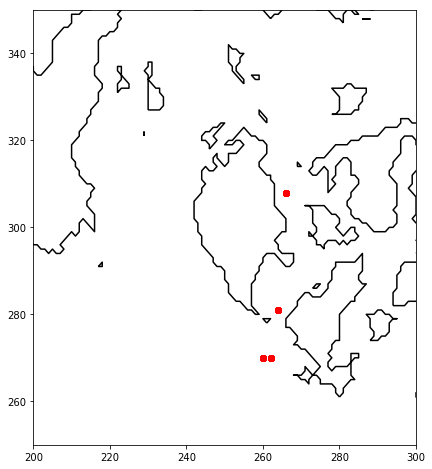

In [43]:
fig, ax = plt.subplots(figsize = ((10,8)))
viz_tools.plot_coastline(ax, grid)
viz_tools.set_aspect(ax)
ax.set_ylim(250,350)
ax.set_xlim(200,300)
ax.plot(list_of_Xinds, list_of_Yinds, 'ro');

In [53]:
np.unique(list_of_depths)

array([ 0.,  4.,  9., 18., 21., 23., 24., 25., 26., 27.])

In [106]:
np.unique(list_of_depths)

array([ 0.,  4.,  9., 18., 21., 23., 24., 25., 26., 27.])

In [107]:
np.unique(list_of_depths2)

array([ 0.,  4.,  9., 14., 18., 21., 23., 24., 25.])

In [122]:
import matplotlib.cm as cm
import cmocean

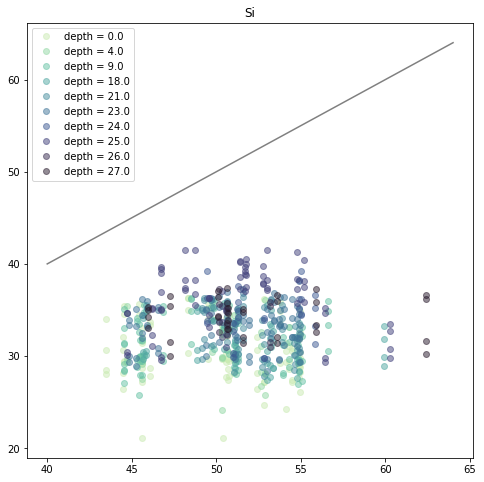

In [124]:
fig, ax = plt.subplots(figsize = (8,8))
colours = cmocean.cm.deep(np.linspace(0,1,11))
for depth, colour in zip(np.unique(list_of_depths), colours[1:]):
    ax.plot(list_of_cs_si[list_of_depths == depth], list_of_model_si[list_of_depths==depth],
            'o', color = colour, alpha = 0.5, label = 'depth = '+str(depth))
ax.plot(np.arange(40,65), np.arange(40,65), color = 'grey')
ax.set_title('Si')
ax.legend();

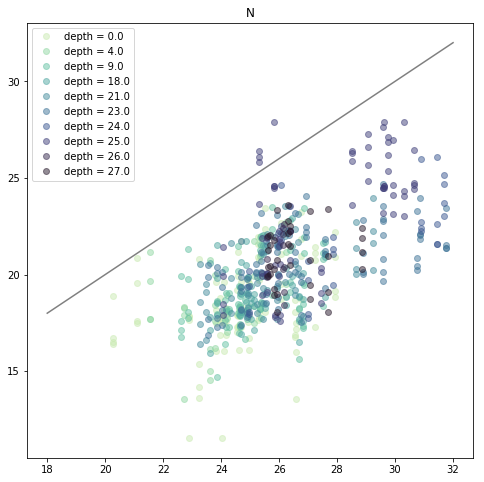

In [125]:
fig, ax = plt.subplots(figsize = (8,8))
colours = cmocean.cm.deep(np.linspace(0,1,11))
for depth, colour in zip(np.unique(list_of_depths), colours[1:]):
    ax.plot(list_of_cs_ni[list_of_depths == depth], list_of_model_ni[list_of_depths==depth],
            'o', color = colour, alpha = 0.5, label = 'depth = '+str(depth))
ax.plot(np.arange(18,33), np.arange(18,33), color = 'grey')
ax.set_title('N')
ax.legend();

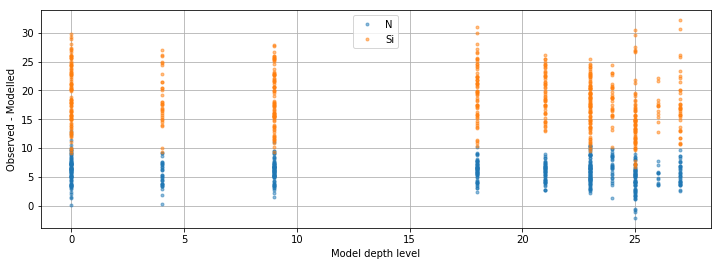

In [59]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_depths, list_of_cs_ni - list_of_model_ni,'.', alpha = 0.5, label = 'N')
ax.plot(list_of_depths, list_of_cs_si - list_of_model_si,'.', alpha = 0.5, label = 'Si')
ax.grid('on')
ax.set_xlabel('Model depth level')
ax.set_ylabel('Observed - Modelled')
ax.legend();

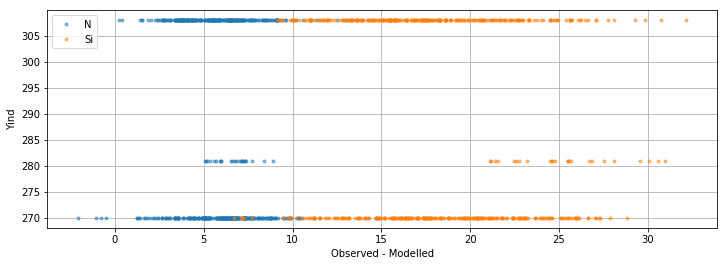

In [80]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_cs_ni - list_of_model_ni,list_of_Yinds,'.', alpha = 0.5, label = 'N')
ax.plot(list_of_cs_si - list_of_model_si,list_of_Yinds,'.', alpha = 0.5, label = 'Si')
ax.grid('on')
ax.set_ylabel('Yind')
ax.set_xlabel('Observed - Modelled')
ax.legend();

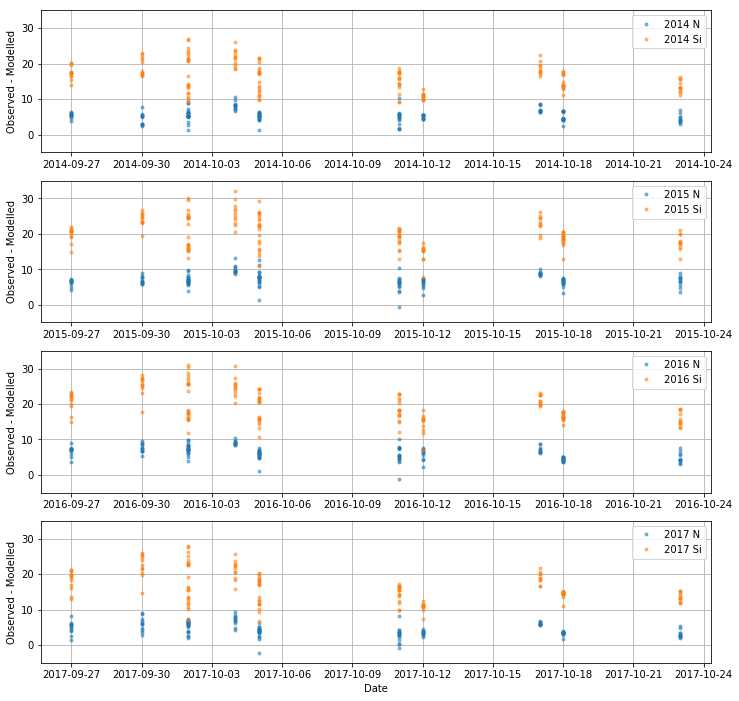

In [69]:
fig, ax = plt.subplots(4,1, figsize = (12,12))
ax[0].plot(list_of_datetimes[list_of_datetimes < datetime.date(2015,1,1)], 
        list_of_cs_ni[list_of_datetimes < datetime.date(2015,1,1)] 
        - list_of_model_ni[list_of_datetimes < datetime.date(2015,1,1)],
        '.', alpha = 0.5, label = '2014 N')
ax[0].plot(list_of_datetimes[list_of_datetimes < datetime.date(2015,1,1)], 
        list_of_cs_si[list_of_datetimes < datetime.date(2015,1,1)] 
        - list_of_model_si[list_of_datetimes < datetime.date(2015,1,1)],
        '.', alpha = 0.5, label = '2014 Si')
ax[0].grid('on')
ax[0].set_ylabel('Observed - Modelled')
ax[0].legend();

ax[1].plot(list_of_datetimes[(list_of_datetimes < datetime.date(2016,1,1)) 
                             & (list_of_datetimes > datetime.date(2015,1,1))], 
        list_of_cs_ni[(list_of_datetimes < datetime.date(2016,1,1)) 
                      & (list_of_datetimes > datetime.date(2015,1,1))] 
        - list_of_model_ni[(list_of_datetimes < datetime.date(2016,1,1)) 
                           & (list_of_datetimes > datetime.date(2015,1,1))],
        '.', alpha = 0.5, label = '2015 N')
ax[1].plot(list_of_datetimes[(list_of_datetimes < datetime.date(2016,1,1)) 
                             & (list_of_datetimes > datetime.date(2015,1,1))], 
        list_of_cs_si[(list_of_datetimes < datetime.date(2016,1,1)) 
                             & (list_of_datetimes > datetime.date(2015,1,1))] 
        - list_of_model_si[(list_of_datetimes < datetime.date(2016,1,1)) 
                             & (list_of_datetimes > datetime.date(2015,1,1))],
        '.', alpha = 0.5, label = '2015 Si')
ax[1].grid('on')
ax[1].set_ylabel('Observed - Modelled')
ax[1].legend();

ax[2].plot(list_of_datetimes[(list_of_datetimes < datetime.date(2017,1,1)) 
                             & (list_of_datetimes > datetime.date(2016,1,1))], 
        list_of_cs_ni[(list_of_datetimes < datetime.date(2017,1,1)) 
                      & (list_of_datetimes > datetime.date(2016,1,1))] 
        - list_of_model_ni[(list_of_datetimes < datetime.date(2017,1,1)) 
                           & (list_of_datetimes > datetime.date(2016,1,1))],
        '.', alpha = 0.5, label = '2016 N')
ax[2].plot(list_of_datetimes[(list_of_datetimes < datetime.date(2017,1,1)) 
                             & (list_of_datetimes > datetime.date(2016,1,1))], 
        list_of_cs_si[(list_of_datetimes < datetime.date(2017,1,1)) 
                             & (list_of_datetimes > datetime.date(2016,1,1))] 
        - list_of_model_si[(list_of_datetimes < datetime.date(2017,1,1)) 
                             & (list_of_datetimes > datetime.date(2016,1,1))],
        '.', alpha = 0.5, label = '2016 Si')
ax[2].grid('on')
ax[2].set_ylabel('Observed - Modelled')
ax[2].legend();

ax[3].plot(list_of_datetimes[(list_of_datetimes > datetime.date(2017,1,1))], 
        list_of_cs_ni[(list_of_datetimes > datetime.date(2017,1,1))] 
        - list_of_model_ni[(list_of_datetimes > datetime.date(2017,1,1))],
        '.', alpha = 0.5, label = '2017 N')
ax[3].plot(list_of_datetimes[(list_of_datetimes > datetime.date(2017,1,1))], 
        list_of_cs_si[ (list_of_datetimes > datetime.date(2017,1,1))] 
        - list_of_model_si[(list_of_datetimes > datetime.date(2017,1,1))],
        '.', alpha = 0.5, label = '2017 Si')
ax[3].grid('on')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Observed - Modelled')
ax[3].legend();

for a in ax:
    a.set_ylim(-5, 35)

In [70]:
f.dropna(subset=['month', 'day', 'depth', 'station', 'chl']).shape

(784, 14)

In [71]:
f3 = f.dropna(subset=['month', 'day', 'depth', 'station', 'chl'])

In [72]:
np.array([datetime.date(2017, f3.month[n], f3.day[n]) for n in f3.index]).min()

datetime.date(2017, 9, 27)

In [73]:
np.array([datetime.date(2017, f3.month[n], f3.day[n]) for n in f3.index]).max()

datetime.date(2017, 11, 19)

In [78]:
list_of_Yinds2 = np.array([])
list_of_Xinds2 = np.array([])
list_of_datetimes2 = np.array([])
list_of_chl = np.array([])
list_of_model_chl = np.array([])
list_of_depths2 = np.array([])
for n in f3.index:
    Yind, Xind = stations[f3.station[n]]
    depth = np.argmin(np.abs(deptht - f3.depth[n]))
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        for year in [2014,2015,2016,2017]:
            date = datetime.date(year, f3.month[n], f3.day[n])
            sub_dir = date.strftime('%d%b%y').lower()
            datestr = date.strftime('%Y%m%d')
            fname = 'SalishSea_1d_{}_{}_ptrc_T.nc'.format(datestr, datestr)
            nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
            chl_val = 1.6*(nuts.variables['diatoms'][0, depth, Yind, Xind] 
                           + nuts.variables['ciliates'][0, depth, Yind, Xind]
                           + nuts.variables['flagellates'][0, depth, Yind, Xind])
            list_of_Yinds2 = np.append(list_of_Yinds2, Yind)
            list_of_Xinds2 = np.append(list_of_Xinds2, Xind)
            list_of_datetimes2 = np.append(list_of_datetimes2, date)
            list_of_chl = np.append(list_of_chl, float(f3['chl'][n]))
            list_of_model_chl = np.append(list_of_model_chl, chl_val)
            list_of_depths2 = np.append(list_of_depths2, depth)

In [118]:
np.unique(list_of_depths2)

array([ 0.,  4.,  9., 14., 18., 21., 23., 24., 25.])

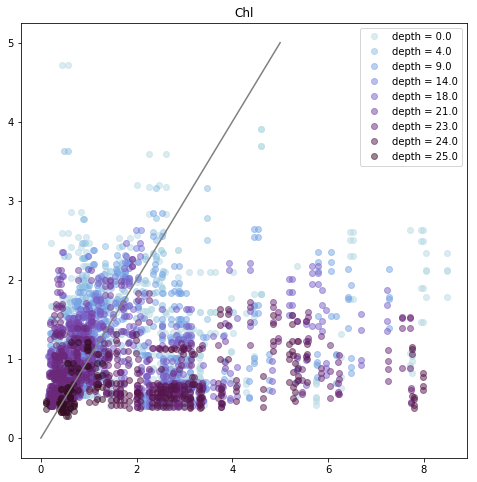

In [126]:
fig, ax = plt.subplots(figsize = (8,8))
colours = cmocean.cm.dense(np.linspace(0,1,10))
for depth, colour in zip(np.unique(list_of_depths2), colours[1:]):
    ax.plot(list_of_chl[list_of_depths2 == depth], list_of_model_chl[list_of_depths2==depth],
            'o', color = colour, alpha = 0.5, label = 'depth = '+str(depth))
ax.plot(np.arange(0,6), np.arange(0,6), color = 'grey')
ax.set_title('Chl')
ax.legend();

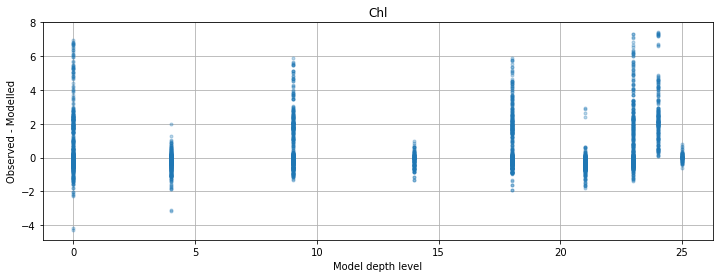

In [83]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_depths2, list_of_chl - list_of_model_chl,'.', alpha = 0.3)
ax.grid('on')
ax.set_xlabel('Model depth level')
ax.set_ylabel('Observed - Modelled')
ax.set_title('Chl');

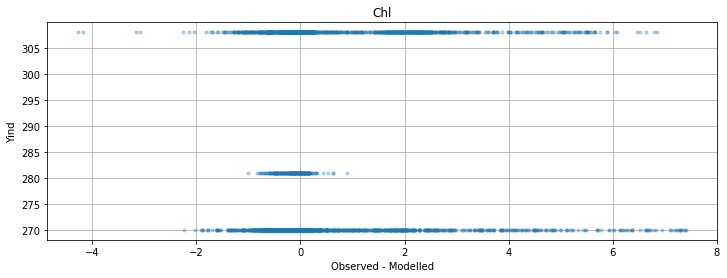

In [84]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(list_of_chl - list_of_model_chl,list_of_Yinds2,'.', alpha = 0.3, label = 'N')
ax.grid('on')
ax.set_ylabel('Yind')
ax.set_xlabel('Observed - Modelled')
ax.set_title('Chl');

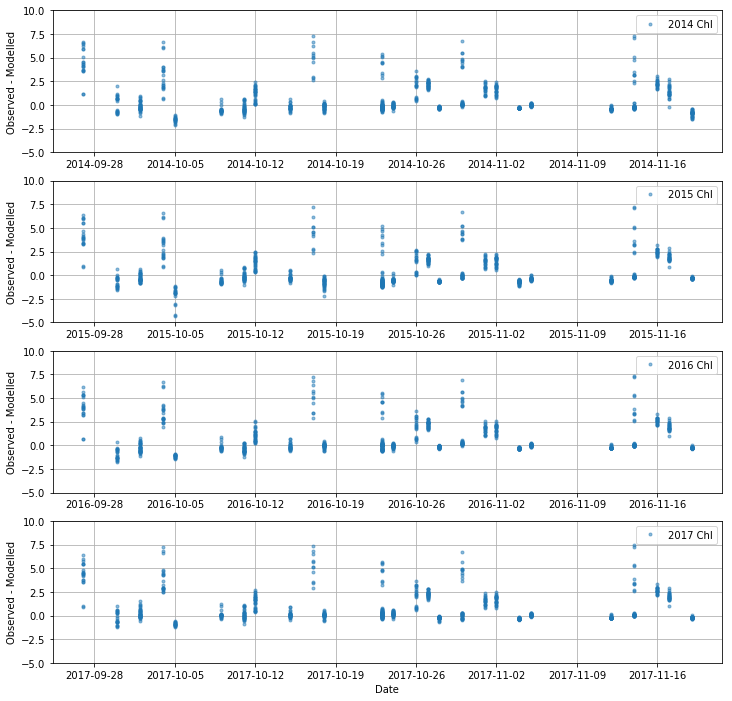

In [86]:
fig, ax = plt.subplots(4,1, figsize = (12,12))
ax[0].plot(list_of_datetimes2[list_of_datetimes2 < datetime.date(2015,1,1)], 
        list_of_chl[list_of_datetimes2 < datetime.date(2015,1,1)] 
        - list_of_model_chl[list_of_datetimes2 < datetime.date(2015,1,1)],
        '.', alpha = 0.5, label = '2014 Chl')
ax[0].grid('on')
ax[0].set_ylabel('Observed - Modelled')
ax[0].legend();

ax[1].plot(list_of_datetimes2[(list_of_datetimes2 < datetime.date(2016,1,1)) 
                             & (list_of_datetimes2 > datetime.date(2015,1,1))], 
        list_of_chl[(list_of_datetimes2 < datetime.date(2016,1,1)) 
                      & (list_of_datetimes2 > datetime.date(2015,1,1))] 
        - list_of_model_chl[(list_of_datetimes2 < datetime.date(2016,1,1)) 
                           & (list_of_datetimes2 > datetime.date(2015,1,1))],
        '.', alpha = 0.5, label = '2015 Chl')
ax[1].grid('on')
ax[1].set_ylabel('Observed - Modelled')
ax[1].legend();

ax[2].plot(list_of_datetimes2[(list_of_datetimes2 < datetime.date(2017,1,1)) 
                             & (list_of_datetimes2 > datetime.date(2016,1,1))], 
        list_of_chl[(list_of_datetimes2 < datetime.date(2017,1,1)) 
                      & (list_of_datetimes2 > datetime.date(2016,1,1))] 
        - list_of_model_chl[(list_of_datetimes2 < datetime.date(2017,1,1)) 
                           & (list_of_datetimes2 > datetime.date(2016,1,1))],
        '.', alpha = 0.5, label = '2016 Chl')
ax[2].grid('on')
ax[2].set_ylabel('Observed - Modelled')
ax[2].legend();

ax[3].plot(list_of_datetimes2[(list_of_datetimes2 > datetime.date(2017,1,1))], 
        list_of_chl[(list_of_datetimes2 > datetime.date(2017,1,1))] 
        - list_of_model_chl[(list_of_datetimes2 > datetime.date(2017,1,1))],
        '.', alpha = 0.5, label = '2017 Chl')
ax[3].grid('on')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Observed - Modelled')
ax[3].legend();

for a in ax:
    a.set_ylim(-5, 10)